<a name = "contents"></a>
# Content

* [1. Data load](#0)
* [2. Data Preprocessing](#1)
* [3. EDA](#2)
* [4. Data Prediction](#3) 

In [2]:
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt  
from pandas.plotting import scatter_matrix
plt.style.use('ggplot')


from sklearn.linear_model import LinearRegression
import pmdarima as pm

from statsmodels.tsa.stattools import adfuller

#Diable the warnings
import warnings
warnings.filterwarnings('ignore') 

<a name = "0"></a>  
# Data load

> Below is a manual collection of CO2 equivalent emission factors for indicators presented in the industrial sector of Kazakhstan. Coefficients were taken according to national sources or IPCC 2006 recommended values

[Contents](#contents)

In [3]:
coefs = {
    'клинкер':{'id':4120253,'std':0.000001, 'group':'2A1', 'count_of_manufacturers':None, 'coef':0.5101 * 1.02,  },
    'известь':{'id':4120264,'std':0.000001, 'group':'2A2', 'count_of_manufacturers':None, 'coef':0.75 },
    'стекло':{'id':4118397,'std':0.001, 'group':'2A3', 'count_of_manufacturers':None, 'coef':0.000051201 },
    'керамика':{'id':4120798,'std':0.000001, 'group':'2A4a', 'count_of_manufacturers':None, 'coef':0.11 },
    #'кальцинированная сода':{'id':,'std':, 'group':'2A4b', 'count_of_manufacturers':None, 'coef': },
    #известняка и доломит:{'id':,'std':, 'group':'2A4d', 'count_of_manufacturers':None, 'coef': },
    'аммиак':{'id':4120582,'std':0.000001, 'group':'2B1', 'count_of_manufacturers':None, 'coef':2.1},
    ##N2O
    'азотная кислота':{'id':4120581,'std':0.000001, 'group':'2B2', 'count_of_manufacturers':None, 'coef':2.3 * 0.298},

     #АО «Темиртауский Электрометаллургический комбинат» 100%
    'карбид кальция':{'id':4123135,'std':0.000001, 'group':'2B5', 'count_of_manufacturers':1, 'coef':2.95},
    'сталь':{'id':4120596,'std': 0.000001, 'group':'2C1a', 'count_of_manufacturers':None, 'coef':0.135 },
    'чугун':{'id':4119978,'std':0.000001 , 'group':'2C1b', 'count_of_manufacturers':None, 'coef':1.89 },
    #'кокс':{'id':4122878,'std': np.NAN, 'group':'', 'count_of_manufacturers':None, 'coef':None},
    'агломерат железорудный':{'id':4121191,'std':0.000001 , 'group':'2C1d', 'count_of_manufacturers':None, 'coef':0.2 },
     #АО «Соколовско-Сарбайское горно-обогатительное производственное объединение (ССГПО)» 100%
    # разница поскольку там использовали уравнение 2 оно выдает больше выбросов
    'окатыши железорудные':{'id':4117218,'std':0.000001 , 'group':'2C1e', 'count_of_manufacturers':1, 'coef':0.03 },
    #'ферросплавы':{'id':4118146,'std': , 'group':'2C2', 'count_of_manufacturers':None, 'coef':},
    'ферросиликохром':{'id':4116902,'std':  0.000001, 'group':'2C2', 'count_of_manufacturers':None, 'coef':1.3},
    'ферросиликомарганец':{'id':4116900,'std': 0.000001, 'group':'2C2', 'count_of_manufacturers':None, 'coef':1.4  },
    'ферросилиций':{'id':4116898,'std': 0.000001, 'group':'2C2', 'count_of_manufacturers':None, 'coef':2.5 },
    'феррохром':{'id':4116760,'std':0.000001 , 'group':'2C2', 'count_of_manufacturers':None, 'coef':1.6 },
    'ферросплавы прочие':{'id':4118105,'std':0.000001 , 'group':'2C2', 'count_of_manufacturers':None, 'coef':1.6  },
    #АО «Казахста́нский электро́лизный заво́д» (КЭЗ) — 100%
    'алюминий':{'id':4119172,'std': 0.000001, 'group':'2C3', 'count_of_manufacturers':1, 'coef':1.87           * 4},#добавил от балжы перепроверить
    #АО «Усть-Каменогорский Титаномагниевый Комбинат» (АО «УКТМК») - -выбросов нет
    #'магний':{'id':0,'std': 0, 'group':'', 'count_of_manufacturers':None, 'coef':0 },
    'свинец':{'id':4116969,'std': 0.000001, 'group':'2C5', 'count_of_manufacturers':None, 'coef':0.52 },
    'цинк':{'id':4116970,'std': 0.000001, 'group':'2C6', 'count_of_manufacturers':None, 'coef':1.72 },
    'Производство смазочных материалов':{'id':4120809,'std': 0.000001, 'group':'2D', 'count_of_manufacturers':None, 'coef':(44/12) * 0.2*40.2  * 0.02},
    #'Битум':{'id':4124448,'std':np.NAN, 'group':'', 'count_of_manufacturers':None, 'coef':None},
    #НМЛОС – неметановые летучие органические соединения
    #'НМЛОС':{'id':4124448,'std':np.NAN, 'group':'', 'count_of_manufacturers':None, 'coef':None},
}
#2D решили пока не брать
#pd.DataFrame(coefs).T.to_excel('./datasets/coefs.xlsx')

In [4]:
def transform_data(df:pd.DataFrame)->pd.DataFrame:
    """Приведение данных с json файла в более читаемый вид"""    
    # parsing json to more usable format
    # Раскрываем list элементы 
    df = df.explode('periods')
    # обозначаем новые колонки и удалям ненужные
    df = df.assign(**{
        'date':df['periods'].str['date'],
        'value':df['periods'].str['value'],
        'region_id':df['terms'].str[0],
        'product_id':df['terms'].str[1],
        'region_name':df['termNames'].str[0],
        'product_name':df['termNames'].str[1],
        }).drop(['terms','termNames','periods'],axis = 1).reset_index()

    # Обозночаем типы данных очевидно
    df['date'] = pd.to_datetime(df['date'],format="%d.%m.%Y")
    df['value'] = df['value'].replace('x',None).astype(float)
    df['region_id'] = df['region_id'].astype(int)
    df['product_id'] = df['product_id'].astype(int)
    df['region_name'] = df['region_name'].astype(str)
    df['product_name'] = df['product_name'].str.upper().astype(str)

    return df

In [5]:
# read main data
PATH_TALDAU = "https://taldau.stat.gov.kz/ru/Api/GetIndexData/701608?period=7&dics=68,1973" 

data = transform_data(pd.read_json(PATH_TALDAU))

# Определяем необходиму выборку
data = data[
    (data['region_name'] == "РЕСПУБЛИКА КАЗАХСТАН")&\
    (data['product_id'].isin([coefs[i]['id'] for i in coefs])) # берем id показателей с короторыми продолжим работу
]

# read index Мин фин 2022 - 2027
PATH_INDEX = './datasets/index_volume.csv'
ind = pd.read_csv(PATH_INDEX)
# preproc
ind['year'] = pd.to_datetime(ind['year']) 
ind['Обрабатывающая промышленность'] = ind['Обрабатывающая промышленность, в % к предыдущему году']/100

print('count of indexes = ',data.shape)
display('taldau data',data.head(3))
display('Прогнозные данные Министерства финансов и фактические',ind.head(3))

count of indexes =  (255, 7)


'taldau data'

,index,date,value,region_id,product_id,region_name,product_name
21593,2044,2014-12-31,1.165385e+10,741880,4120798,РЕСПУБЛИКА КАЗАХСТАН,"КИРПИЧИ, ПЛИТКИ И ИЗДЕЛИЯ СТРОИТЕЛЬНЫЕ ИЗ ГЛИН..."
21594,2044,2020-12-31,1.713860e+10,741880,4120798,РЕСПУБЛИКА КАЗАХСТАН,"КИРПИЧИ, ПЛИТКИ И ИЗДЕЛИЯ СТРОИТЕЛЬНЫЕ ИЗ ГЛИН..."
21595,2044,2021-12-31,2.193454e+10,741880,4120798,РЕСПУБЛИКА КАЗАХСТАН,"КИРПИЧИ, ПЛИТКИ И ИЗДЕЛИЯ СТРОИТЕЛЬНЫЕ ИЗ ГЛИН..."


'Прогнозные данные Министерства финансов и фактические'

,year,Численность населения,"Промышленность, в % к предыдущему году","Горнодобывающая промышленность и разработка карьеров, в % к предыдущему году","Обрабатывающая промышленность, в % к предыдущему году","Строительство, в % к предыдущему году",Статус,Обрабатывающая промышленность
0,2000-12-31,14 883 626,NaN,NaN,NaN,NaN,факт,NaN
1,2001-12-31,14 858 335,NaN,NaN,NaN,NaN,факт,NaN
2,2002-12-31,14 858 948,NaN,NaN,NaN,NaN,факт,NaN


<a name = "1"></a>
# Data Preprocessing and EDA
[Contents](#contents)

**interpolating values**

In [6]:
def prepoc(df):
    """
    Функция  проходит по кажому показателю
    проверяет на наличие обязательного периода(2010 - 2021)
    интерполирует значения 
    и добавляет новые переменные заданные в таблице - coefs
    """
    dataframes = []
    for i in coefs:
        temp_df = df[df['product_id'] == coefs[i]['id']].sort_values('date')
        temp_df = pd.merge(temp_df,
                             pd.DataFrame({'date':pd.to_datetime(pd.Series([str(i)+'-12-31' for i in range(2010,2022)]))}),
                             on='date',
                             how='outer').sort_values('date')
        temp_df['value'] = temp_df['value'].interpolate()
        temp_df['name'] = i
        temp_df['value'] = temp_df['value'] * coefs[i]['std']
        temp_df['group'] = coefs[i]['group']
        temp_df['CO2'] = temp_df['value'] * coefs[i]['coef']
        dataframes.append(temp_df)
    df = pd.concat(dataframes)
    df['group_main'] = df['group'].str[:2]
        
    return df
data = prepoc(data)

<a name = "2"></a>
# EDA
[Contents](#contents)

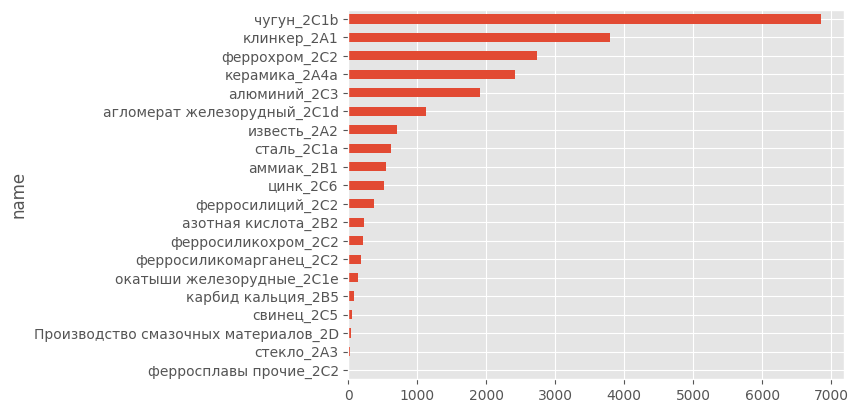

In [7]:
def amount_plot(df:pd.DataFrame)->plt:
    df.assign(**{'name':df['name'] +'_'+ df['group']})[
      ((df.date.dt.year == 2021))
    ].sort_values('CO2').set_index('name')['CO2'].plot(kind = 'barh')

amount_plot(data)

		adfuller-test
Test Statistic                -3.59401
p-value                        0.00588
#Lags Used                     4.00000
Number of Observations Used    7.00000
Critical Value (1%)           -4.93869
Critical Value (5%)           -3.47758
Critical Value (10%)          -2.84387
dtype: float64


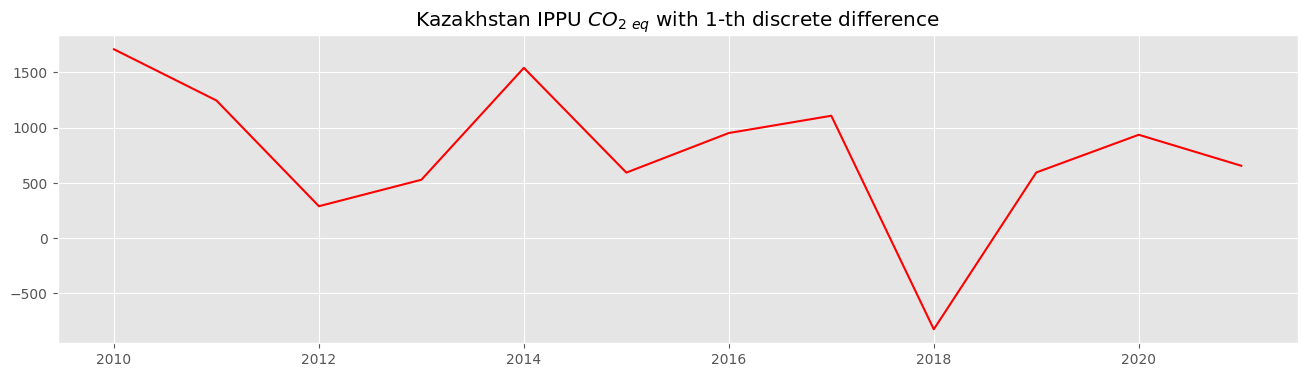

In [8]:
def stationarity(ts, window, n):
    roll_mean = ts.rolling(window).mean()
    roll_std = ts.rolling(window).std()
    
    plt.figure(figsize = (16, 4))
    
    plt.plot(ts[:n], color = 'red')
    #plt.plot(roll_mean[:n], label = 'Скользящее среднее', color = 'blue')
    #plt.plot(roll_std[:n], label = 'Скользящее стандартное отклонение', color = 'green')
    plt.title("Kazakhstan IPPU $CO_{2 \ eq}$ with 1-th discrete difference")
    #plt.legend(loc = 'best')
    #plt.show(block = False)
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print('\t\tadfuller-test')
    print(round(dfoutput,5))
    
dts = data.pivot_table(index = data.date.dt.year,aggfunc='sum',columns = 'group_main',values = 'CO2').sum(axis = 1).diff(1).dropna()
stationarity(dts,2,len(dts))

<AxesSubplot: title={'center': 'Kazakhstan IPPU $CO_{2 \\ eq}$'}, xlabel='date'>

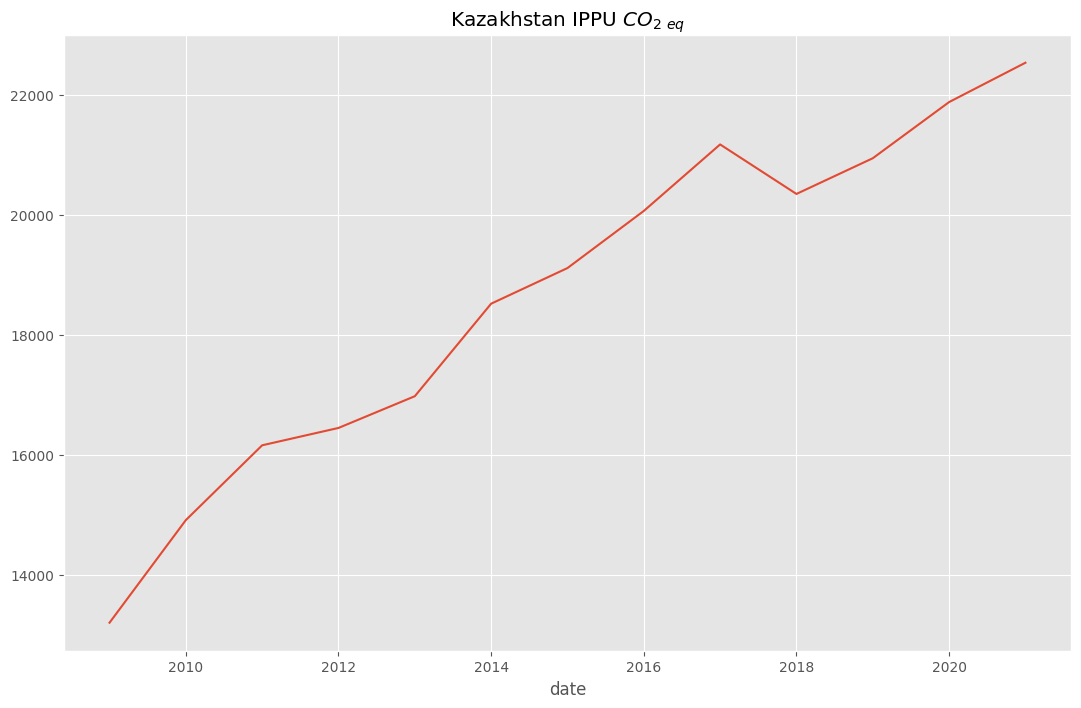

In [11]:
data.pivot_table(index = data.date.dt.year,aggfunc='sum',columns = 'group_main',values = 'CO2').sum(axis = 1).plot(
    title = 'Kazakhstan IPPU $CO_{2 \ eq}$',
    figsize = (13,8))

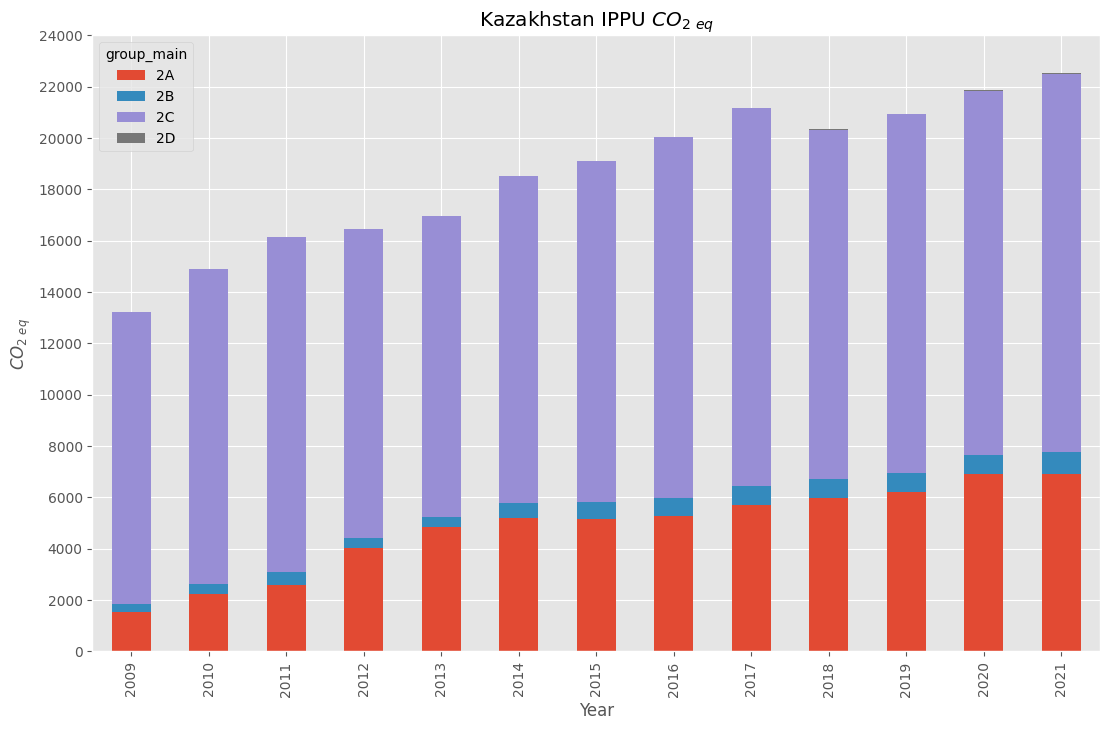

In [12]:
data.pivot_table(index = data.date.dt.year,aggfunc='sum',columns = 'group_main',values = 'CO2')\
.plot(kind = 'bar',stacked = True,figsize = (13,8),yticks =  [i for i in range(0,25000,2000)],
      ylabel = '$CO_{2 \ eq}$ ',
      xlabel = 'Year',
      title = 'Kazakhstan IPPU $CO_{2 \ eq}$');
#plt.savefig('./img/kz_ippo_c02.png')

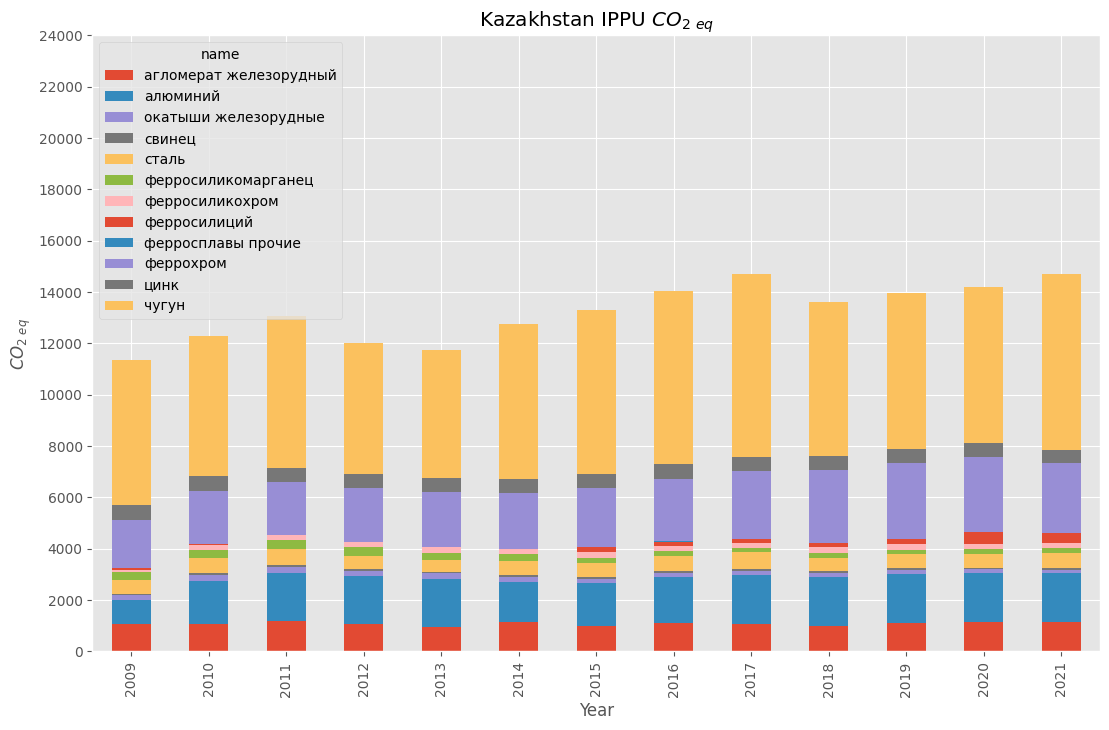

In [13]:
data[data['group_main']=='2C'].pivot_table(index = data[data['group_main']=='2C'].date.dt.year,aggfunc='sum',columns = 'name',values = 'CO2')\
.plot(kind = 'bar',stacked = True,figsize = (13,8),yticks =  [i for i in range(0,25000,2000)],
      ylabel = '$CO_{2 \ eq}$ ',
      xlabel = 'Year',
      title = 'Kazakhstan IPPU $CO_{2 \ eq}$');
#plt.savefig('./img/kz_ippo_c02.png')

<AxesSubplot: ylabel='2021'>

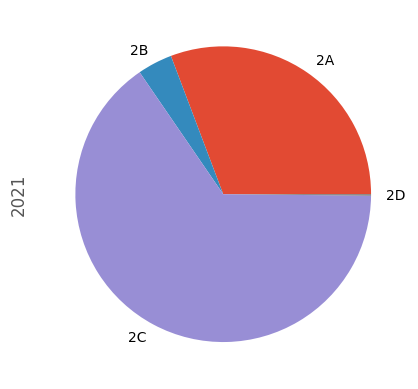

In [14]:
data.pivot_table(index = data.date.dt.year,aggfunc='sum',columns = 'group_main',values = 'CO2').iloc[-1].plot(kind = 'pie')

<a name = "3"></a>
# Data Prediction
[Contents](#contents)

In [15]:
def pred_by_index(df,n_periods = 6):
    """
    Прогнозирование выбросов СО2 на базе прогноза
    СОЦИАЛЬНО-ЭКОНОМИЧЕСКОГО РАЗВИТИЯ
    РЕСПУБЛИКИ КАЗАХСТАН Промышленного производства от Министра национальной экономики РК
    """
    data = {}
    for param in coefs:
        tmp_last = df[(df['date'] == '2021-12-31')&(df['name'] == param)]['value'].values[0]
        tmp_data = []
        for i in range(2022,2028):
            tmp_data.append(tmp_last * ind[ind['year'].dt.year ==i]['Обрабатывающая промышленность'].iloc[0])
            tmp_last *= ind[ind['year'].dt.year ==i]['Обрабатывающая промышленность'].iloc[0]
        #CO2
        #data[param] = np.array(tmp_data).astype(float) * coefs[param]['coef']
        #value
        data[param] = np.array(tmp_data).astype(float)
        ##forecast

        #df_temp =pd.merge(ind[['year','Обрабатывающая промышленность']],df_temp
        #         ,how = 'left',left_on ='date',right_on = 'year')
    return pd.DataFrame(data,index= pd.to_datetime([str(i) +'-12-31' for i in range(2022,2022 + n_periods)]))


In [16]:
#передает параметры по одному
def one_by_one(df,model,n_periods = 6):
    df_X = df.pivot_table(columns = 'name',index = 'date',values = 'value').iloc[1:]
    data = []
    for i in df_X.columns:
        #print(i)
        data.append( pd.DataFrame(model(df_X[i],n_periods), columns = [i]))
    data = pd.concat(data,axis = 1)#.sum(axis = 1)
    #lin.index = pd.to_datetime([str(i) +'-12-31' for i in range(2022,2028)])
    return data


def linear(df:pd.Series,n_periods = 6):
    """прогнозирует стандартную линейную регрессию по одному показателю"""
    X = df.index.year.values.reshape(-1,1)
    Y = df.values.reshape(-1,1)
    model = LinearRegression()
    model.fit(X,Y)
    pred = model.predict(np.arange(2022,2022 + n_periods).reshape(-1,1))
    pred = pd.Series(data = pred.reshape(-1),
                     index = pd.to_datetime([str(i) +'-12-31' for i in range(2022,2022 + n_periods)]))
    #print(pred)
    return pred


def arima(df:pd.Series,n_periods = 6):
    smodel = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=1,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                         stepwise=True)
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='YS')

    
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    return fitted

def sarimax(df:pd.Series,n_periods = 6,m=3):
    smodel = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf',
                         max_p=10, max_q=10, m=m,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=False,
                         error_action='ignore',  
                         suppress_warnings=True,
                         stepwise=True)
    try:
        fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='YS')


        lower_series = pd.Series(confint[:, 0], index=index_of_fc)
        upper_series = pd.Series(confint[:, 1], index=index_of_fc)

        return fitted
    except:
        print('False')
        return None
  

In [17]:
pred_arima = one_by_one(data,arima,6 +7)
pred_linear = one_by_one(data,linear,6 +7)
pred_index  = pred_by_index(data,6)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=98.169, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=94.373, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=95.115, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=96.291, Time=0.03 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.684 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=170.280, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=171.375, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=169.297, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)

 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=50.079, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=43.884, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=41.188, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=42.038, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=41.483, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=43.187, Time=0.02 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 0.349 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=108.178, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=111.633, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=107.207, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=108.575, Time=0

In [18]:
pred_sarimax = one_by_one(data,sarimax,6 +7)

False


In [19]:
display(pred_arima)
display(pred_linear)
display(pred_index)

,Производство смазочных материалов,агломерат железорудный,азотная кислота,алюминий,аммиак,известь,карбид кальция,керамика,клинкер,окатыши железорудные,свинец,сталь,стекло,ферросиликомарганец,ферросиликохром,ферросилиций,ферросплавы прочие,феррохром,цинк,чугун
2022-12-31,77.325731,5791.803128,380.028,255.09,302.251,958.438208,27.612987,26730.480,7174.882344,4814.3,111.361,5042.740,432699.007632,135.775414,158.825,202.873467,-0.360351,1470.711933,294.815859,4035.153
2023-12-31,89.216980,5934.506255,425.622,255.09,344.400,1024.751228,26.906131,31526.418,7056.065443,4814.3,111.361,5559.409,462263.815265,142.671767,158.825,200.339768,-0.376928,1158.243229,288.745719,4446.542
2024-12-31,103.727696,6077.209383,471.216,255.09,386.549,1068.973927,26.906131,36322.356,6939.216164,4814.3,111.361,6076.078,491828.622897,147.732812,158.825,235.451543,-0.642215,782.118711,282.675578,4857.931
2025-12-31,116.578807,6219.912510,516.810,255.09,428.698,1124.955855,26.906131,41118.294,6824.301923,4814.3,111.361,6592.747,521393.430530,153.833493,158.825,245.866929,-0.859386,354.454113,276.605437,5269.320
2026-12-31,130.481388,6362.615638,562.404,255.09,470.847,1174.678053,26.906131,45914.232,6711.290675,4814.3,111.361,7109.416,550958.238162,159.345257,158.825,272.483775,-0.985016,-114.940846,270.535296,5680.709
2027-12-31,143.717793,6505.318766,607.998,255.09,512.996,1227.732461,26.906131,50710.170,6600.150907,4814.3,111.361,7626.085,580523.045794,165.190621,158.825,288.472050,-1.251076,-618.123547,264.465156,6092.098
2028-12-31,157.376264,6648.021893,653.592,255.09,555.145,1279.013050,26.906131,55506.108,6490.851626,4814.3,111.361,8142.754,610087.853427,170.847013,158.825,311.432938,-1.401494,-1148.663104,258.395015,6503.487
2029-12-31,170.767329,6790.725021,699.186,255.09,597.294,1331.237887,26.906131,60302.046,6383.362355,4814.3,111.361,8659.423,639652.661059,176.610451,158.825,329.819615,-1.607888,-1701.352636,252.324874,6914.876
2030-12-31,184.327813,6933.428149,744.780,255.09,639.443,1382.960078,26.906131,65097.984,6277.653119,4814.3,111.361,9176.092,669217.468692,182.313251,158.825,351.207091,-1.815954,-2271.976296,246.254733,7326.265
2031-12-31,197.780959,7076.131276,790.374,255.09,681.592,1434.949840,26.906131,69893.922,6173.694440,4814.3,111.361,9692.761,698782.276324,188.050400,158.825,370.625967,-1.988204,-2857.120648,240.184593,7737.654


,Производство смазочных материалов,агломерат железорудный,азотная кислота,алюминий,аммиак,известь,карбид кальция,керамика,клинкер,окатыши железорудные,свинец,сталь,стекло,ферросиликомарганец,ферросиликохром,ферросилиций,ферросплавы прочие,феррохром,цинк,чугун
2022-12-31,55.966667,5483.187879,359.042924,256.772121,270.620288,901.673439,27.698750,19347.891742,9294.183333,4096.328788,136.173242,4208.974833,402349.703030,91.813000,159.900939,154.210288,0.260864,1900.053242,313.152242,3592.519591
2023-12-31,60.743590,5495.380886,376.894246,258.783537,285.003396,900.405828,27.860038,20496.801882,9811.448718,3780.706294,138.887805,4216.173179,422879.020163,79.622077,160.094558,168.991050,0.111279,1957.093459,312.189690,3651.430579
2024-12-31,65.520513,5507.573893,394.745568,260.794953,299.386505,899.138216,28.021327,21645.712022,10328.714103,3465.083800,141.602368,4223.371526,443408.337296,67.431154,160.288177,183.771812,-0.038307,2014.133676,311.227138,3710.341568
2025-12-31,70.297436,5519.766900,412.596889,262.806369,313.769613,897.870604,28.182615,22794.622162,10845.979487,3149.461305,144.316931,4230.569872,463937.654429,55.240231,160.481796,198.552575,-0.187892,2071.173893,310.264585,3769.252556
2026-12-31,75.074359,5531.959907,430.448211,264.817786,328.152721,896.602992,28.343904,23943.532302,11363.244872,2833.838811,147.031494,4237.768218,484466.971562,43.049308,160.675415,213.333337,-0.337477,2128.214110,309.302033,3828.163544
2027-12-31,79.851282,5544.152914,448.299533,266.829202,342.535830,895.335380,28.505192,25092.442442,11880.510256,2518.216317,149.746057,4244.966564,504996.288695,30.858385,160.869034,228.114099,-0.487062,2185.254326,308.339480,3887.074533
2028-12-31,84.628205,5556.345921,466.150854,268.840618,356.918938,894.067768,28.666481,26241.352582,12397.775641,2202.593823,152.460620,4252.164910,525525.605828,18.667462,161.062653,242.894861,-0.636647,2242.294543,307.376928,3945.985521
2029-12-31,89.405128,5568.538928,484.002176,270.852034,371.302047,892.800156,28.827769,27390.262721,12915.041026,1886.971329,155.175183,4259.363256,546054.922960,6.476538,161.256272,257.675624,-0.786232,2299.334760,306.414375,4004.896509
2030-12-31,94.182051,5580.731935,501.853498,272.863450,385.685155,891.532544,28.989058,28539.172861,13432.306410,1571.348834,157.889746,4266.561603,566584.240093,-5.714385,161.449890,272.456386,-0.935817,2356.374977,305.451823,4063.807498
2031-12-31,98.958974,5592.924942,519.704819,274.874866,400.068263,890.264932,29.150346,29688.083001,13949.571795,1255.726340,160.604309,4273.759949,587113.557226,-17.905308,161.643509,287.237148,-1.085402,2413.415193,304.489270,4122.718486


,клинкер,известь,стекло,керамика,аммиак,азотная кислота,карбид кальция,сталь,чугун,агломерат железорудный,окатыши железорудные,ферросиликохром,ферросиликомарганец,ферросилиций,феррохром,ферросплавы прочие,алюминий,свинец,цинк,Производство смазочных материалов
2022-12-31,7507.275300,960.698067,414825.091800,22570.643718,267.644958,344.132586,28.771869,4657.327059,3728.853156,5812.923900,4953.914700,163.430925,135.950451,152.315667,1753.993269,0.080262,262.487610,114.590469,309.611694,63.077700
2023-12-31,7747.508110,991.440405,428099.494738,23292.904317,276.209597,355.144829,29.692569,4806.361525,3848.176457,5998.937465,5112.439970,168.660715,140.300865,157.189768,1810.121054,0.082830,270.887214,118.257364,319.519268,65.096186
2024-12-31,8018.670893,1026.140819,443082.977053,24108.155968,285.876933,367.574898,30.731809,4974.584178,3982.862633,6208.900276,5291.375369,174.563840,145.211396,162.691410,1873.475290,0.085729,280.368266,122.396372,330.702443,67.374553
2025-12-31,8275.268362,1058.977326,457261.632319,24879.616959,295.024994,379.337294,31.715227,5133.770872,4110.314237,6407.585085,5460.699381,180.149882,149.858160,167.897535,1933.426500,0.088473,289.340051,126.313056,341.284921,69.530539
2026-12-31,8531.801681,1091.805623,471436.742921,25650.885085,304.170769,391.096751,32.698399,5292.917769,4237.733979,6606.220223,5629.981062,185.734529,154.503763,173.102359,1993.362721,0.091215,298.309592,130.228760,351.864753,71.685985
2027-12-31,8932.796360,1143.120487,493594.269838,26856.476684,318.466795,409.478298,34.235223,5541.684904,4436.907476,6916.712573,5894.590172,194.464052,161.765440,181.238170,2087.050769,0.095503,312.330143,136.349512,368.402397,75.055227


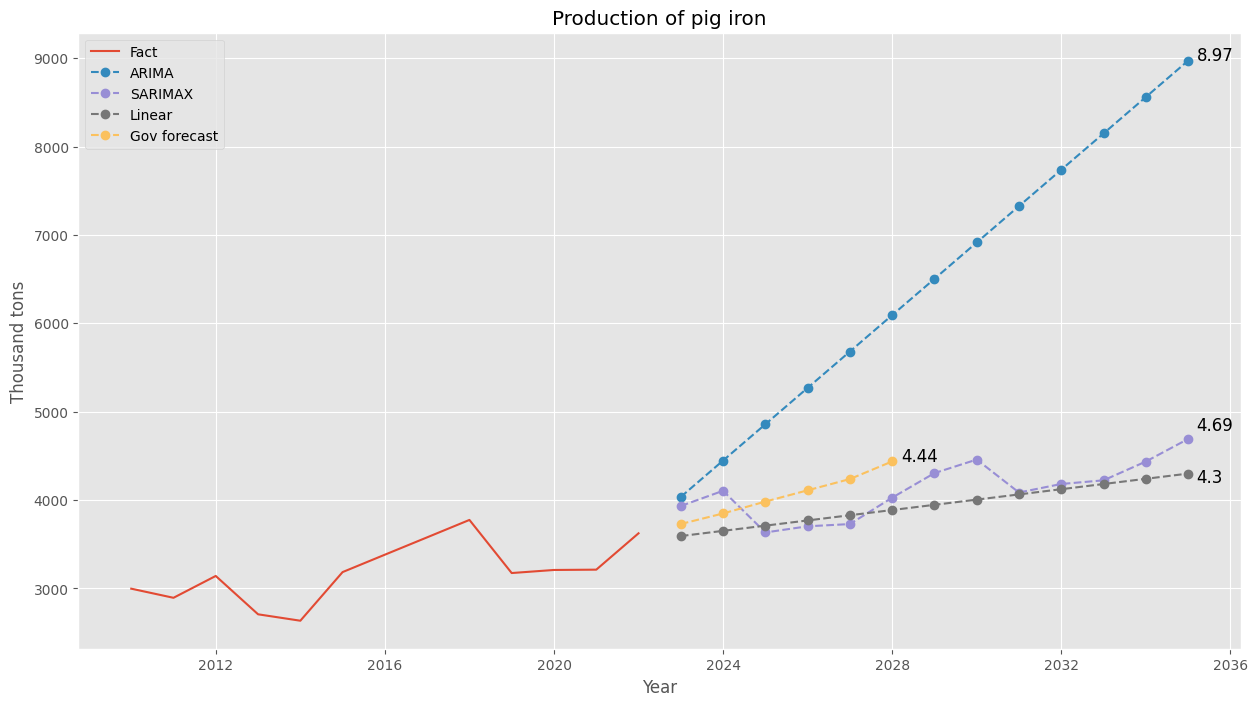

In [20]:
def pred_plot(df,param = 'чугун',title = 'Production of pig iron'):
    
    one_param_df = pd.concat([df[(df['name'] == param)].set_index('date')[['value']].rename(columns = {'value':'Fact'}),
    pd.concat([pred_arima[[param]].rename(columns = {'чугун':'arima'}),
    pred_linear[[param]].rename(columns = {'чугун':'Linear'}),
    pred_index[[param]].rename(columns = {'чугун':'Index'})],axis = 1)])

    sarimax_for_one_param_df = sarimax(data[(data['name'] == param)].set_index('date')['value'],6 + 7,m = 3)
    sarimax_for_one_param_df.name = 'sarimax'
    
    one_param_df = pd.concat([one_param_df,sarimax_for_one_param_df],axis = 1)


    plt.figure(figsize=(15,8))
    plt.title(title)
    plt.plot(one_param_df['Fact'].dropna(), label = 'Fact')
    plt.plot(one_param_df['arima'].dropna(),'--o',label = 'ARIMA')
    plt.plot(one_param_df['sarimax'].dropna(),'--o',label = 'SARIMAX')
    plt.plot(one_param_df['Linear'].dropna(),'--o',label = 'Linear')
    plt.plot(one_param_df['Index'].dropna(),'--o',label = 'Gov forecast')

    plt.text(y = one_param_df['arima'].iloc[-1],
            x = pd.Timestamp("2035-03-15"),
            s = np.round(one_param_df['arima'].iloc[-1]/1000,2),
            fontsize=12)
    plt.text(y = one_param_df['sarimax'].iloc[-1] +100,
            x = pd.Timestamp("2035-03-15"),
            s = np.round(one_param_df['sarimax'].iloc[-1]/1000,2),
            fontsize=12)
    plt.text(y = one_param_df['Linear'].iloc[-1]-100,
            x = pd.Timestamp("2035-03-15"),
            s = np.round(one_param_df['Linear'].iloc[-1]/1000,2),
            fontsize=12)
    plt.text(y = one_param_df['Index'].dropna().iloc[-1],
            x = pd.Timestamp("2028-03-15"),
            s = np.round(one_param_df['Index'].dropna().iloc[-1]/1000,2),
            fontsize=12)

    plt.xlabel('Year')
    plt.ylabel('Thousand tons')
    plt.legend()

pred_plot(data,param = 'чугун',title = 'Production of pig iron')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


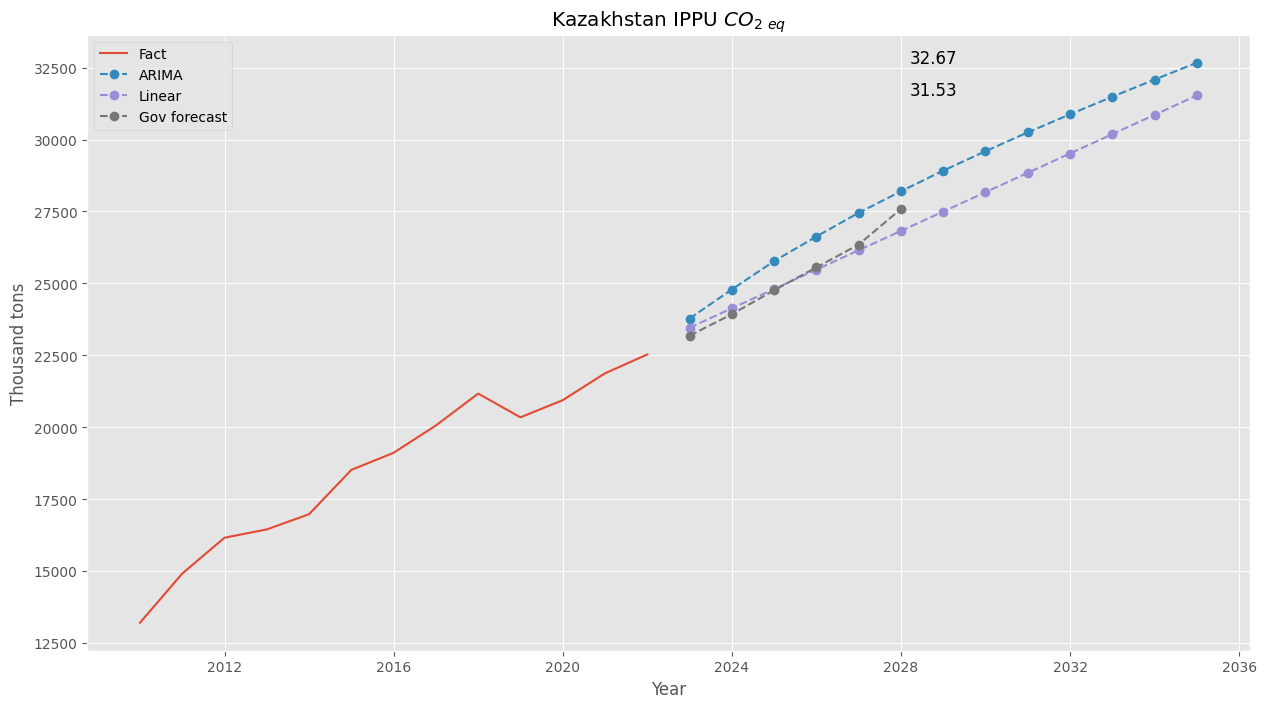

In [21]:
def total_carb_pred_plot(df):
    
    pred_arima['model'] = 'ARIMA'
    pred_linear['model'] = 'Linear'
    pred_index['model'] = 'Gov'

    pred = pd.concat([
        pred_arima.reset_index().melt(id_vars=['index','model']),
        pred_linear.reset_index().melt(id_vars=['index','model']),
        pred_index.reset_index().melt(id_vars=['index','model'])
    ])
    pred['group'] = 'None'
    for name in coefs:
        pred['group'][pred['variable'] == name] = coefs[name]['group']
        pred['value'][pred['variable'] == name] *= coefs[name]['coef'] 
    pred['group'] = pred['group'].str[:2]
    total_carb_prediction = pred.pivot_table(index = 'index',columns = ['model'],values = 'value',aggfunc = 'sum')#.plot()##.groupby(['model','group']).sum()

    plt.figure(figsize=(15,8))
    plt.title( 'Kazakhstan IPPU $CO_{2 \ eq}$')
    plt.plot(df.groupby('date').sum()['CO2'],label = 'Fact')
    #plt.plot(total_carb_prediction['ARIMA'].dropna(),'--o',label = 'ARIMA')
    plt.plot(total_carb_prediction['ARIMA'].dropna(),'--o',label = 'ARIMA')
    plt.plot(total_carb_prediction['Linear'].dropna(),'--o',label = 'Linear')
    plt.plot(total_carb_prediction['Gov'].dropna(),'--o',label = 'Gov forecast')

    plt.text(y = total_carb_prediction['ARIMA'].iloc[-1],
            x = pd.Timestamp("2028-03-15"),
            s = np.round(total_carb_prediction['ARIMA'].iloc[-1]/1000,2),
            fontsize=12)
    plt.text(y = total_carb_prediction['Linear'].iloc[-1],
            x = pd.Timestamp("2028-03-15"),
            s = np.round(total_carb_prediction['Linear'].iloc[-1]/1000,2),
            fontsize=12)
    plt.text(y = total_carb_prediction['Gov'].iloc[-1],
            x = pd.Timestamp("2028-03-15"),
            s = np.round(total_carb_prediction['Gov'].iloc[-1]/1000,2),
            fontsize=12)
    plt.xlabel('Year')
    plt.ylabel('Thousand tons')
    plt.legend()

total_carb_pred_plot(data)